In [6]:
!git clone https://github.com/miskcoo/kscore

fatal: destination path 'kscore' already exists and is not an empty directory.


In [7]:
%cd kscore

/content/kscore/kscore


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
#!cp drive/MyDrive/kscore .
#import kscore
import sys
sys.path.insert(0,'/content/drive/My Drive/kscore')
sys.path.insert(0,'/content/drive/My Drive')

In [10]:
! pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!ls
#%cd ..
#%cd MyDrive


estimators  __init__.py  kernels  utils.py


In [11]:
%load_ext autoreload
%autoreload 2

In [71]:
from abc import abstractmethod
from tikhonov import *
from base import *
from basek import *
from curlfree_gaussian import *
from landweber import *
from nu_method import *
from spectral_cutoff import *
from stein import *
from diagonal_gaussian import *
#import data_generator
from data_generator import *
from diagonal_imq import *


# Tikhonov regularization (Theorem 3.1), equivalent to KEF (Example 3.5)
kef_estimator = Tikhonov(lam=0.0001, use_cg=False, kernel=DiagonalGaussian())

# Tikhonov regularization + Conjugate Gradient (KEF-CG, Example 3.8)
kefcg_estimator = Tikhonov(lam=0.0001, use_cg=True, kernel=CurlFreeIMQ())

# Tikhonov regularization + Nystrom approximation (Appendix C.1), 
# equivalent to NKEF (Example C.1) using 60% samples
nkef_estimator = Tikhonov(lam=0.0001, use_cg=False, subsample_rate=0.05, kernel=DiagonalGaussian())

# Tikhonov regularization + Nystrom approximation + Conjugate Gradient
nkefcg_estimator = Tikhonov(lam=0.0001, use_cg=True, subsample_rate=0.6, kernel=CurlFreeIMQ())

# Landweber iteration (Theorem 3.4)
landweber_estimator = Landweber(lam=0.00001, kernel=CurlFreeIMQ())
landweber_estimator = Landweber(iternum=100, kernel=CurlFreeIMQ())

# nu-method (Example C.4)
nu_estimator = NuMethod(lam=0.00001, kernel=CurlFreeIMQ())
nu_estimator = NuMethod(iternum=100, kernel=CurlFreeIMQ())

# Spectral cut-off regularization (Theorem 3.2), 
# equivalent to SSGE (Example 3.6) using 90% eigenvalues
ssge_estimator = SpectralCutoff(keep_rate=0.9, kernel=DiagonalIMQ())

# Original Stein estimator
stein_estimator = Stein(lam=0.1)

In [72]:
import matplotlib.pyplot as plt
# Generate data
np.random.seed(0)

#p = GaussianGridWrapped(D=2, sigma=0.1, N_train=1000, N_test=1500)
p = Ring(D=2, sigma=0.1, N_train=2000, N_test=500)

X,X_test = p.sample_train_test()
D = X.shape[1]


In [ ]:
plt.plot(X[:,0], X[:,1],'.')
samples = tf.cast(X, dtype=tf.float32)
print(samples.shape)
print(0.05*2000)

In [104]:
def plot_vector_field(X, Y, normalize=False):
    if normalize:
        for i in range(Y.shape[0]):
            norm = (Y[i][0] ** 2 + Y[i][1] ** 2) ** 0.5
            Y[i] /= norm
    plt.quiver(X[:,0], X[:,1], Y[:,0], Y[:,1], color='green')


def visualise_array_2d(Xs, Ys, A, samples=None, ax=None):
    # visualise found fit
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    vmin = np.nanmin(A)
    vmax = np.nanmax(A)
    heatmap = ax.pcolor(Xs, Ys, A.T, cmap='viridis', vmin=vmin, vmax=vmax)
    heatmap.cmap.set_under('white')
    
    colorbar = plt.colorbar(heatmap, ax=ax)
    colorbar.set_clim(vmin=vmin, vmax=vmax)
    
    if samples is not None:
        ax.scatter(samples[:, 0], samples[:, 1], c='r', s=1);


In [16]:
#@title score functions
import math
import numpy as np

from functools import reduce
from scipy.spatial.distance import cdist
import numba


@numba.njit(parallel=True,fastmath=True)
def my_cdist(r,y, output,dist='euclidean'):
    """   
    Fast computation of pairwise distances between data points in r and y matrices.
    Stores the distances in the output array.
    Available distances: 'euclidean' and 'seucledian'
    
    Parameters
    ----------
    r : NxM array
        First set of N points of dimension M.
    y : N2xM array
        Second set of N2 points of dimension M.
    output : NxN2 array
        Placeholder for storing the output of the computed distances.
    dist : type of distance, optional
        Select 'euclidian' or 'sqeuclidian' for Euclidian or squared Euclidian
        distances. The default is 'euclidean'.

    Returns
    -------
    None. (The result is stored in place in the provided array "output").

    """
    N, M = r.shape
    N2, M2 = y.shape
    #assert( M == M2, 'The two inpus have different second dimention! Input should be N1xM and N2xM')
    if dist == 'euclidean':
        for i in numba.prange(N):
            for j in numba.prange(N2):
                tmp = 0.0
                for k in range(M):
                    tmp += (r[i, k] - y[j, k])**2            
                output[i,j] = math.sqrt(tmp)
    elif dist == 'sqeuclidean':
        for i in numba.prange(N):
            for j in numba.prange(N2):
                tmp = 0.0
                for k in range(M):
                    tmp += (r[i, k] - y[j, k])**2            
                output[i,j] = tmp   
    elif dist == 'l1':
        for i in numba.prange(N):
            for j in numba.prange(N2):
                tmp = 0.0
                for k in range(M):
                    tmp += (r[i, k] - y[j, k])**2          
                output[i,j] = math.sqrt(tmp)   
    return 0


def score_function_multid_seperate_all_dims(X,Z,func_out=False, C=0.001,kern ='RBF',l=1):
    """
    Sparse kernel based estimation of multidimensional logarithmic gradient of empirical density represented 
    by samples X for all dimensions simultaneously. 
    
    - When `funct_out == False`: computes grad-log at the sample points.
    - When `funct_out == True`: return a function for the grad log to be employed for interpolation/estimation of grad log 
                               in the vicinity of the samples.
    
    Parameters
    -----------
            X: N x dim array,
               N samples from the density (N x dim), where dim>=2 the 
               dimensionality of the system.
            Z: M x dim array,
              inducing points points (M x dim).
            func_out : Boolean, 
                      True returns function, 
                      if False returns grad-log-p evaluated on samples X.                    
            l: float or array-like,
               lengthscale of rbf kernel (scalar or vector of size dim).
            C: float,
              weighting constant 
              (leave it at default value to avoid unreasonable contraction 
              of deterministic trajectories).
            kern: string,
                options:
                    - 'RBF': radial basis function/Gaussian kernel  
                    - 'periodic': periodic, not functional yet.           
           
    Returns
    -------
        res1: array with logarithmic gradient of the density  N_s x dim or function 
                 that accepts as inputs 2dimensional arrays of dimension (K x dim), where K>=1.
    
    """
    
    if kern=='RBF':
        """
        #@numba.njit(parallel=True,fastmath=True)
        def Knumba(x,y,l,res,multil=False): #version of kernel in the numba form when the call already includes the output matrix
            if multil:                                        
                for ii in range(len(l)): 
                    tempi = np.zeros((x[:,ii].size, y[:,ii].size ), dtype=np.float64)
                    ##puts into tempi the cdist result                    
                    my_cdist(x[:,ii:ii+1], y[:,ii:ii+1],tempi,'sqeuclidean')
                    
                    res = np.multiply(res,np.exp(-tempi/(2*l[ii]*l[ii])))                    
                    
            else:
                tempi = np.zeros((x.shape[0], y.shape[0] ), dtype=np.float64)                
                my_cdist(x, y,tempi,'sqeuclidean') #this sets into the array tempi the cdist result
                res = np.exp(-tempi/(2*l*l))
            return 0
        """
        
        def K(x,y,l,multil=False):
            if multil:   
                res = np.ones((x.shape[0],y.shape[0]))                
                for ii in range(len(l)): 
                    tempi = np.zeros((x[:,ii].size, y[:,ii].size ))
                    ##puts into tempi the cdist result
                    my_cdist(x[:,ii].reshape(-1,1), y[:,ii].reshape(-1,1),tempi,'sqeuclidean')
                    res = np.multiply(res,np.exp(-tempi/(2*l[ii]*l[ii])))                    
                    
                return res
            else:
                tempi = np.zeros((x.shape[0], y.shape[0] ))
                
                my_cdist(x, y,tempi,'sqeuclidean') #this sets into the array tempi the cdist result
                return np.exp(-tempi/(2*l*l))
            
        
        def grdx_K_all(x,y,l,multil=False): #gradient with respect to the 1st argument - only which_dim
            N,dim = x.shape    
            M,_ = y.shape
            diffs = x[:,None]-y                         
            redifs = np.zeros((1*N,M,dim))
            for ii in range(dim):          
            
                if multil:
                    redifs[:,:,ii] = np.multiply(diffs[:,:,ii],K(x,y,l,True))/(l[ii]*l[ii])   
                else:
                    redifs[:,:,ii] = np.multiply(diffs[:,:,ii],K(x,y,l))/(l*l)            
            return redifs
            
        
        def grdx_K(x,y,l,which_dim=1,multil=False): #gradient with respect to the 1st argument - only which_dim
            #_,dim = x.shape 
            #M,_ = y.shape
            diffs = x[:,None]-y                         
            #redifs = np.zeros((1*N,M))
            ii = which_dim -1            
            if multil:
                redifs = np.multiply(diffs[:,:,ii],K(x,y,l,True))/(l[ii]*l[ii])  
                
            else:
                redifs = np.multiply(diffs[:,:,ii],K(x,y,l))/(l*l)            
            return redifs
     
        
            #############################################################################
    elif kern=='periodic': ###############################################################################################
        ### DO NOT USE "periodic" yet!!!!!!!
      ###periodic kernel
        ## K(x,y) = exp(  -2 * sin^2( pi*| x-y  |/ (2*pi)  )   /l^2)
        
        ## Kx(x,y) = (K(x,y)* (x - y) cos(abs(x - y)/2) sin(abs(x - y)/2))/(l^2 abs(x - y))
        ## -(2 K(x,y) π (x - y) sin((2 π abs(x - y))/per))/(l^2 s abs(x - y))
      #per = 2*np.pi ##period of the kernel
      
      def K(x,y,l,multil=False):
        
        if multil:       
          res = np.ones((x.shape[0],y.shape[0]))                
          for ii in range(len(l)): 
              #tempi = np.zeros((x[:,ii].size, y[:,ii].size ))
              ##puts into tempi the cdist result
              #my_cdist(x[:,ii].reshape(-1,1), y[:,ii].reshape(-1,1),tempi, 'l1')              
              #res = np.multiply(res, np.exp(- 2* (np.sin(tempi/ 2 )**2) /(l[ii]*l[ii])) )
              res = np.multiply(res, np.exp(- 2* (np.sin(cdist(x[:,ii].reshape(-1,1), y[:,ii].reshape(-1,1),'minkowski', p=1)/ 2 )**2) /(l[ii]*l[ii])) )
          return -res
        else:
            #tempi = np.zeros((x.shape[0], y.shape[0] ))
            ##puts into tempi the cdist result
            #my_cdist(x, y, tempi,'l1')
            #res = np.exp(-2* ( np.sin( tempi / 2 )**2 ) /(l*l) )
            res = np.exp(-2* ( np.sin( cdist(x, y,'minkowski', p=1) / 2 )**2 ) /(l*l) )
            return res
        
      def grdx_K(x,y,l,which_dim=1,multil=False): #gradient with respect to the 1st argument - only which_dim
          #N,dim = x.shape            
          diffs = x[:,None]-y             
          #redifs = np.zeros((1*N,N))
          ii = which_dim -1          
          if multil:
              redifs = np.divide( np.multiply( np.multiply( np.multiply( -2*K(x,y,l,True),diffs[:,:,ii] ),np.sin( np.abs(diffs[:,:,ii]) / 2) ) ,np.cos( np.abs(diffs[:,:,ii])  / 2) ) , (l[ii]*l[ii]* np.abs(diffs[:,:,ii]))  ) 
          else:
              redifs = np.divide( np.multiply( np.multiply( np.multiply( -2*diffs[:,:,ii],np.sin( np.abs(diffs[:,:,ii]) / 2) ) ,K(x,y,l) ),np.cos( np.abs(diffs[:,:,ii]) / 2) ) ,(l*l* np.abs(diffs[:,:,ii])) )           
          return -redifs

    #dim = X.shape[1]

    if isinstance(l, (list, tuple, np.ndarray)):
       multil = True
       ### for different lengthscales for each dimension 
       #K_xz =  np.ones((X.shape[0],Z.shape[0]), dtype=np.float64) 
       #Knumba(X,Z,l,K_xz,multil=True) 
       
       #Ks =  np.ones((Z.shape[0],Z.shape[0]), dtype=np.float64) 
       #Knumba(Z,Z,l,Ks,multil=True) 
       K_xz = K(X,Z,l,multil=True) 
       Ks = K(Z,Z,l,multil=True)    
       
       #print(Z.shape)
       Ksinv = np.linalg.inv(Ks+ 1e-3 * np.eye(Z.shape[0]))
       A = K_xz.T @ K_xz    
              
       gradx_K = -grdx_K_all(X,Z,l,multil=True) #-
       #gradxK = np.zeros((X.shape[0],Z.shape[0],dim))
       #for ii in range(dim):
           #gradxK[:,:,ii] = -grdx_K(X,Z,l,multil=True,which_dim=ii+1)
       
       #np.testing.assert_allclose(gradxK, gradx_K) 
    else:
        multil = False
        
        K_xz = K(X,Z,l,multil=False) 
        
        Ks = K(Z,Z,l,multil=False)    
        
        Ksinv = np.linalg.inv(Ks+ 1e-3 * np.eye(Z.shape[0]))
        A = K_xz.T @ K_xz    
        
        gradx_K = -grdx_K_all(X,Z,l,multil=False)   #shape: (N,M,dim)
    sumgradx_K = np.sum(gradx_K ,axis=0) ##last axis will have the gradient for each dimension ### shape (M, dim)
    
    if func_out==False: #if output wanted is evaluation at data points
        
        # res1 = np.zeros((N, dim))    
        # ### evaluatiion at data points
        # for di in range(dim):
        #     res1[:,di] = -K_xz @ np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0]))@ Ksinv@sumgradx_K[:,di]
        
        
        res1 = -K_xz @ np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0]))@ Ksinv@sumgradx_K        
        
        #res1 = np.einsum('ik,kj->ij', -K_xz @ np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0]))@ Ksinv, sumgradx_K)
        
        
    else:           
        #### for function output 
        if multil:      
            if kern=='RBF':      
                K_sz = lambda x: reduce(np.multiply, [ np.exp(-cdist(x[:,iii].reshape(-1,1), Z[:,iii].reshape(-1,1),'sqeuclidean')/(2*l[iii]*l[iii])) for iii in range(x.shape[1]) ])        
                
            elif kern=='periodic':
                K_sz = lambda x: np.multiply(np.exp(-2*(np.sin( cdist(x[:,0].reshape(-1,1), Z[:,0].reshape(-1,1), 'minkowski', p=2)/(l[0]*l[0])))),np.exp(-2*(np.sin( cdist(x[:,1].reshape(-1,1), Z[:,1].reshape(-1,1),'sqeuclidean')/(l[1]*l[1])))))
            
        else:
            if kern=='RBF':
                K_sz = lambda x: np.exp(-cdist(x, Z,'sqeuclidean')/(2*l*l))
            elif kern=='periodic':
                K_sz = lambda x: np.exp(-2* ( np.sin( cdist(x, Z,'minkowski', p=1) / 2 )**2 ) /(l*l) )
            

        res1 = lambda x: K_sz(x) @ ( -np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0])) ) @ Ksinv@sumgradx_K
        
            
        #np.testing.assert_allclose(res2, res1)
    
    return res1   ### shape out N x dim



In [17]:
#@title plotting specifications
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 'figure'
plt.rcParams['savefig.facecolor'] = (1,1,1,0)
plt.rcParams['savefig.bbox'] = 'standard'#"tight"
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'     # not available in Colab
plt.rcParams['font.sans-serif'] = 'Verdana'#'Helvetica'  # not available in Colab
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.rc('axes',edgecolor='#4f4949')
plt.rcParams['figure.frameon'] = False
#plt.rcParams['figure.subplot.hspace'] = 0.05
#plt.rcParams['figure.subplot.wspace'] = 0.05
#plt.rcParams['figure.subplot.left'] = 0.4
#plt.rcParams['figure.subplot.right'] = 0.5            
plt.rcParams['text.usetex'] = False


In [90]:
estimator_kef = kef_estimator#nu_estimator#
estimator_nkef = nkef_estimator 
estimator_stein = stein_estimator
# manually specify the hyperparameter
estimator_stein.fit(samples, kernel_hyperparams=0.5)

# automatically choose the hyperparameter (using the median trick)
estimator_kef.fit(samples)
estimator_nkef.fit(samples)
#estimator_stein.fit(samples)

In [19]:
res = 50
x_min = np.min(X[:,0])
x_max = np.max(X[:,0])
y_min = np.min(X[:,1])
y_max = np.max(X[:,1])
Xs = np.linspace(x_min,x_max, res)
Ys = np.linspace(y_min,y_max,res)
XX, YY = np.meshgrid(Xs, Ys)
X_grid = np.array([XX.ravel(), YY.ravel()]).T

In [20]:
test_samples = tf.cast(X_grid, dtype=tf.float32)

In [91]:
gradient_kef = estimator_kef.compute_gradients(test_samples)
gradient_nkef = estimator_nkef.compute_gradients(test_samples)
gradient_stein = estimator_stein.compute_gradients(test_samples)

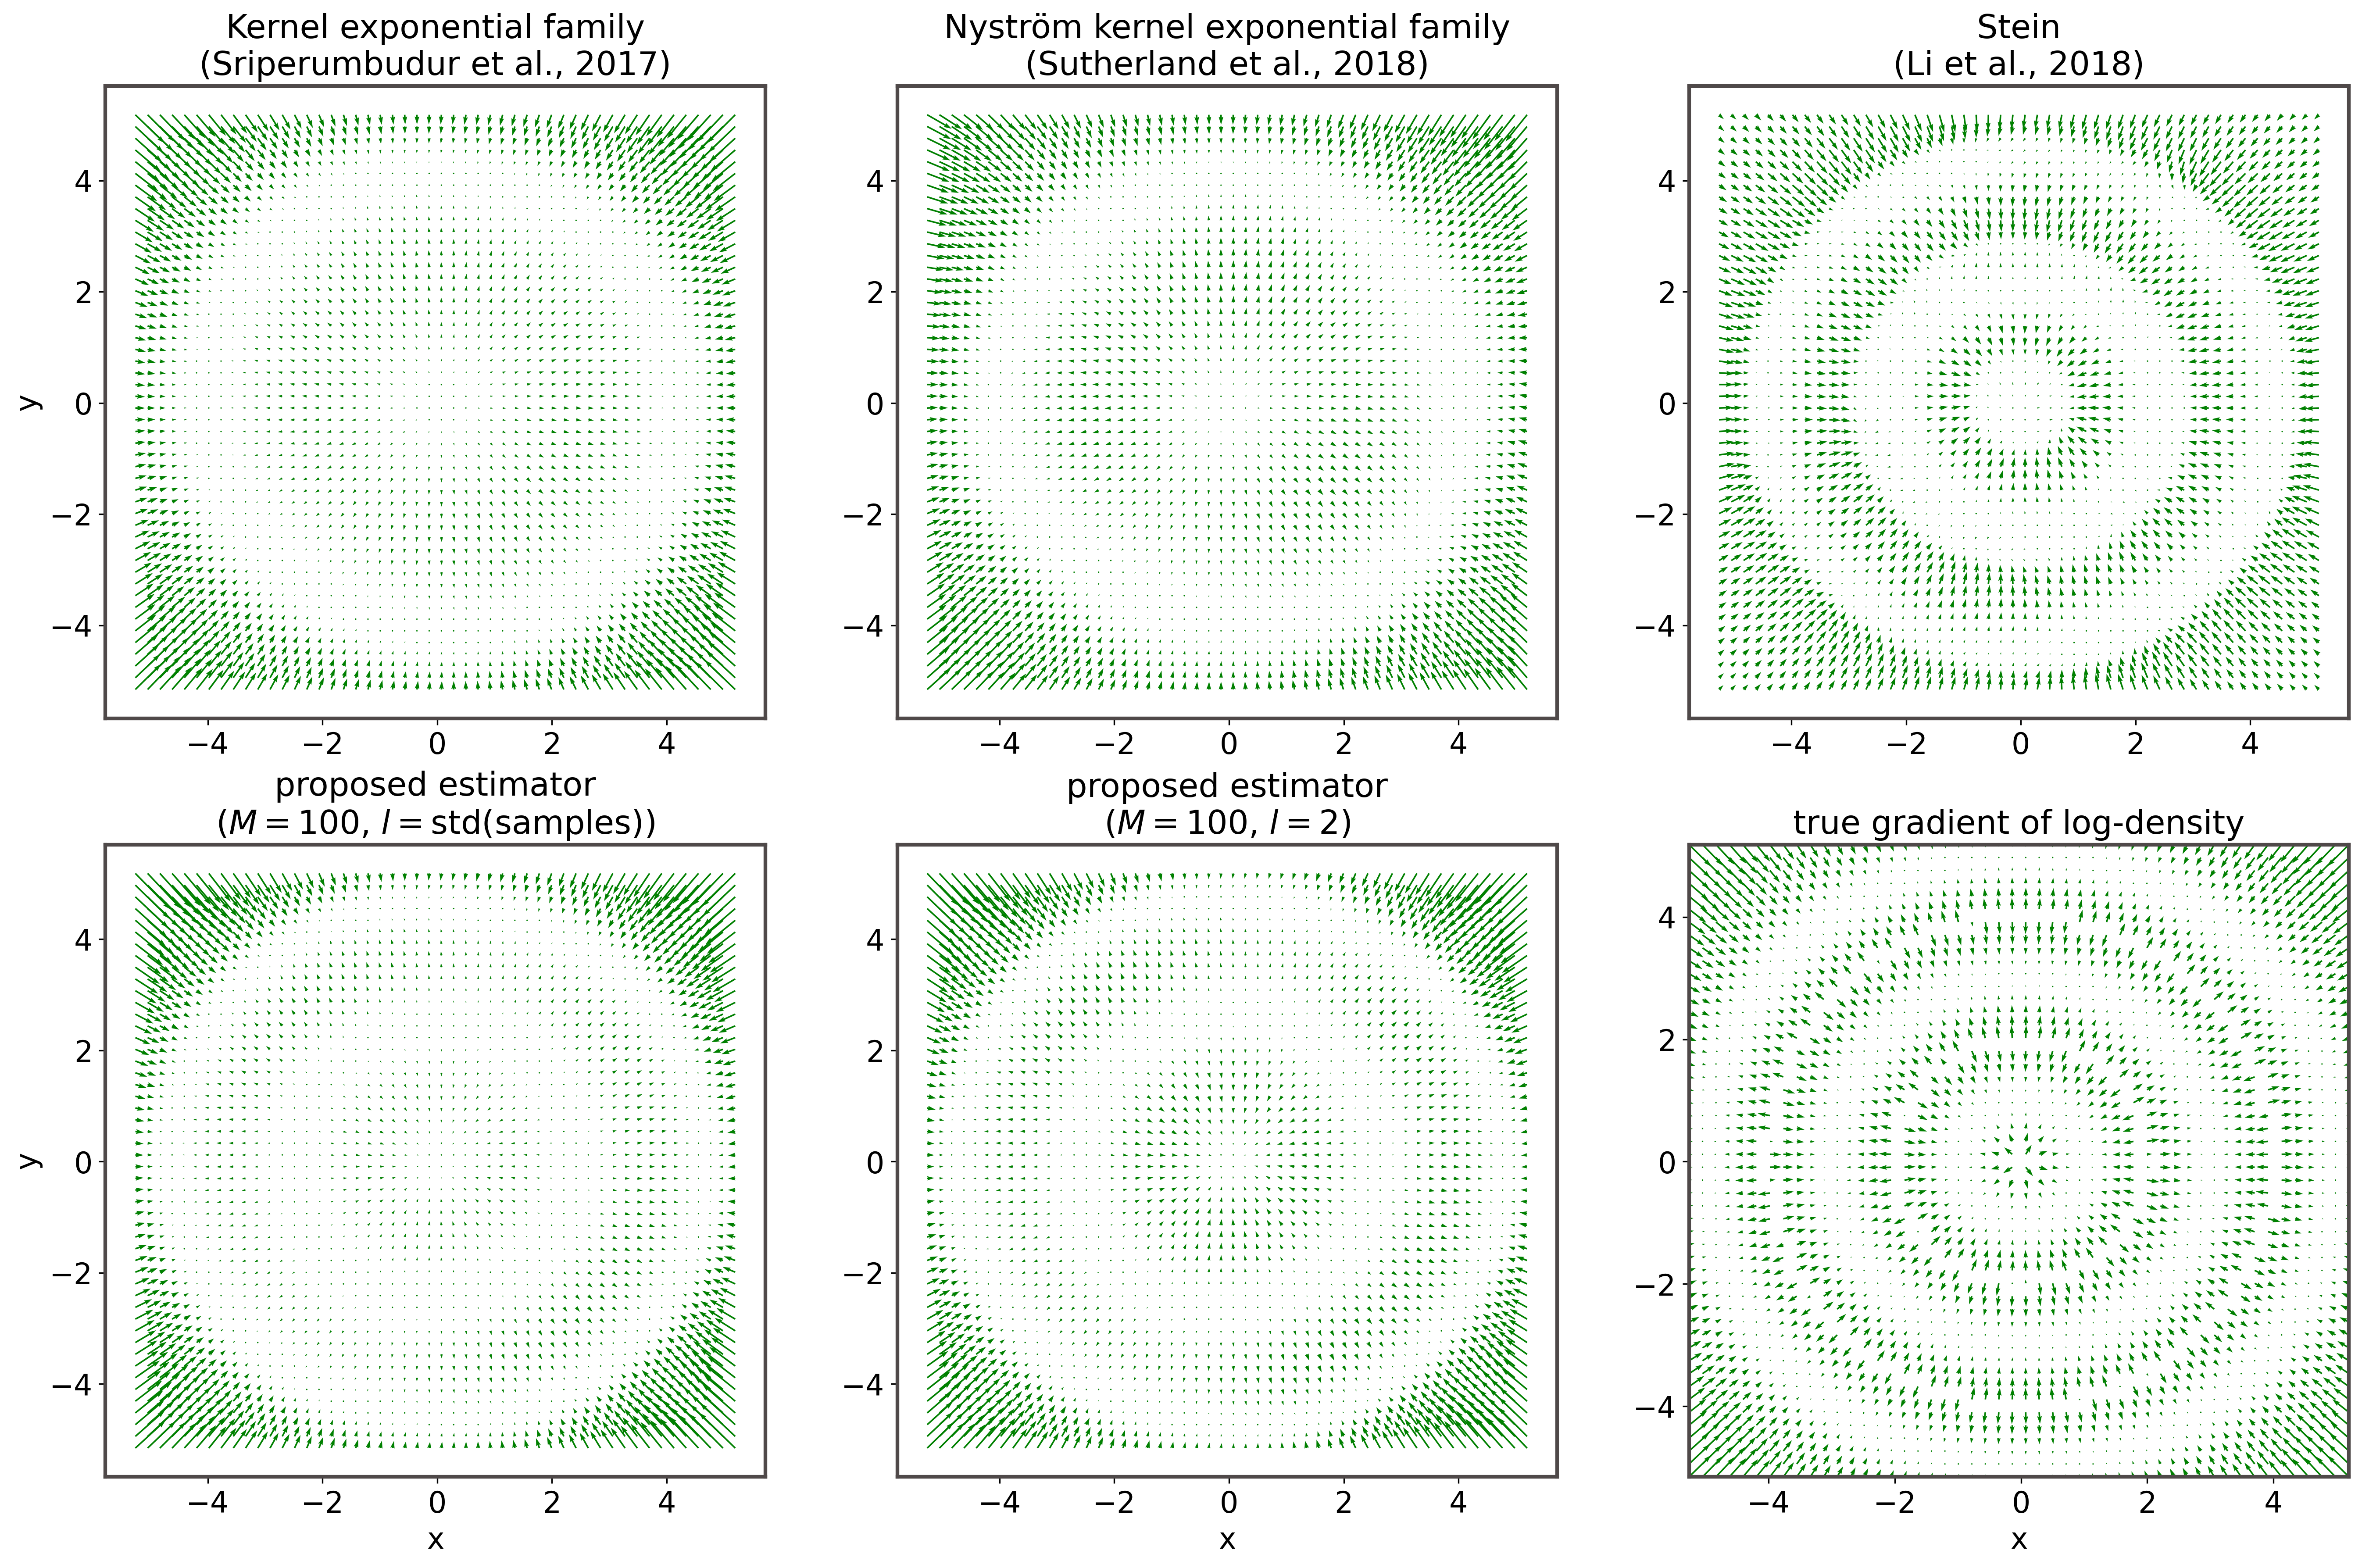

In [107]:
# plot the score field
fig = plt.figure(figsize=(22, 14))
plt.subplot(2,3,1)
grad_grid_norm = np.linalg.norm(gradient_kef, axis=1)
#visualise_array_2d(Xs, Ys, grad_grid_norm.reshape(len(Ys), len(Xs)).T,
#                   samples=samples, ax=plt.gca())
#plt.scatter(samples[:,0], samples[:,1], 10, c='r')
plot_vector_field(test_samples, gradient_kef)
plt.ylabel('y',fontsize=16)
plt.title("Kernel exponential family\n(Sriperumbudur et al., 2017)",fontsize=18)
#######################################
plt.subplot(2,3,2)
grad_grid_norm = np.linalg.norm(gradient_nkef, axis=1)
#visualise_array_2d(Xs, Ys, grad_grid_norm.reshape(len(Ys), len(Xs)).T,
#                   samples=samples, ax=plt.gca())
#plt.scatter(samples[:,0], samples[:,1], 10, c='r')
plot_vector_field(test_samples, gradient_nkef)
plt.title("Nyström kernel exponential family\n(Sutherland et al., 2018)",fontsize=18)
#################################################

plt.subplot(2,3,3)
grad_grid_norm = np.linalg.norm(gradient_stein, axis=1)
#visualise_array_2d(Xs, Ys, grad_grid_norm.reshape(len(Ys), len(Xs)).T,
#                   samples=samples, ax=plt.gca())
#plt.scatter(samples[:,0], samples[:,1], 10, c='r')
plot_vector_field(test_samples, gradient_stein)
plt.title("Stein\n(Li et al., 2018)",fontsize=18)
###########################################mine
#################################################################################
M1 =100
bnds = np.zeros((2, 2))
for ii in range(2):
    bnds[ii] = [np.min(samples[:,ii]), np.max(samples[:,ii])]
sum_bnds = np.sum(bnds) 
Sxx1 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])


bnds = np.zeros((2, 2))
for ii in range(2):
    bnds[ii] = [np.min(samples[:,ii]), np.max(samples[:,ii])]
sum_bnds = np.sum(bnds) 
Sxx2 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])



sx1 = score_function_multid_seperate_all_dims(np.array(samples), Sxx1.T, True, C=1,
                                              l=np.std(samples,axis=0))
sx2 = score_function_multid_seperate_all_dims(np.array(samples), Sxx2.T, True,C=1,
                                              l=np.ones(2)*2.5)

gradient_sx1 = sx1(np.array(test_samples))
gradient_sx2 = sx2(np.array(test_samples))
plt.subplot(2,3,4)
grad_grid_norm = np.linalg.norm(gradient_stein, axis=1)
#visualise_array_2d(Xs, Ys, grad_grid_norm.reshape(len(Ys), len(Xs)).T,
#                   samples=samples, ax=plt.gca())
#plt.scatter(samples[:,0], samples[:,1], 10, c='r')
plot_vector_field(test_samples, gradient_sx1)
plt.title("proposed estimator\n($M=100$, $l=$std(samples))",fontsize=18)
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.subplot(2,3,5)
plot_vector_field(test_samples, gradient_sx2)
plt.title("proposed estimator\n($M=100$, $l=2$)",fontsize=18)
plt.xlabel('x',fontsize=16)
#########################true gradient
plt.subplot(2,3,6)
grad_grid_true = p.grad_multiple(test_samples)
grad_grid_true_norm = np.linalg.norm(grad_grid_true, axis=1)
#visualise_array_2d(Xs, Ys, grad_grid_true_norm.reshape(len(Ys), len(Xs)).T,
#                    samples=samples, ax=plt.gca())
plt.quiver(XX, YY, grad_grid_true[:,0], grad_grid_true[:,1], units='width', color='green')
plt.title("true gradient of log-density",fontsize=18)
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('x',fontsize=16)
#plt.show()

plt.savefig("comparison_estimators.png", bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')
plt.savefig("comparison_estimators.pdf", bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')


In [110]:
np.arange(0,5600,500)

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
       5500])

In [133]:
sizes = np.arange(0,5600,500)[1:]
reps = 10
errors = dict()
errors['kef'] = np.zeros((sizes.size, reps))
errors['nkef'] = np.zeros((sizes.size, reps))
errors['stein'] = np.zeros((sizes.size, reps))
errors['my1'] = np.zeros((sizes.size, reps))
errors['my2'] = np.zeros((sizes.size, reps))
nerrors = dict()
nerrors['kef'] = np.zeros((sizes.size, reps))
nerrors['nkef'] = np.zeros((sizes.size, reps))
nerrors['stein'] = np.zeros((sizes.size, reps))
nerrors['my1'] = np.zeros((sizes.size, reps))
nerrors['my2'] = np.zeros((sizes.size, reps))
for si,sample_size in enumerate(sizes):
  for repi in range(reps):
    np.random.seed(repi)
    p = Ring(D=2, sigma=0.1, N_train=sample_size, N_test=500)
    X,X_test = p.sample_train_test()
    samples = tf.cast(X, dtype=tf.float32)
    estimator_kef = kef_estimator#nu_estimator#
    estimator_nkef = nkef_estimator 
    estimator_stein = stein_estimator
    # manually specify the hyperparameter
    estimator_stein.fit(samples, kernel_hyperparams=0.5)

    # automatically choose the hyperparameter (using the median trick)
    estimator_kef.fit(samples)
    estimator_nkef.fit(samples)
    
    M1 =100
    bnds = np.zeros((2, 2))
    for ii in range(2):
        bnds[ii] = [np.min(samples[:,ii]), np.max(samples[:,ii])]
    sum_bnds = np.sum(bnds) 
    Sxx1 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])


    bnds = np.zeros((2, 2))
    for ii in range(2):
        bnds[ii] = [np.min(samples[:,ii]), np.max(samples[:,ii])]
    sum_bnds = np.sum(bnds) 
    Sxx2 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])
    sx1 = score_function_multid_seperate_all_dims(np.array(samples), Sxx1.T, True, C=1,
                                                  l=np.std(samples,axis=0))
    sx2 = score_function_multid_seperate_all_dims(np.array(samples), Sxx2.T, True,C=1,
                                                  l=np.ones(2)*2.5)
    ###compute gradients
    gradient_kef = estimator_kef.compute_gradients(test_samples)
    gradient_nkef = estimator_nkef.compute_gradients(test_samples)
    gradient_stein = estimator_stein.compute_gradients(test_samples) 
    gradient_sx1 = sx1(np.array(test_samples))
    gradient_sx2 = sx2(np.array(test_samples)) 
    grad_grid_true = p.grad_multiple(test_samples)
    ###errors
    errors['kef'][si,repi] = np.mean( np.power( gradient_kef- grad_grid_true   ,2))
    errors['nkef'][si,repi] = np.mean( np.power( gradient_nkef- grad_grid_true   ,2))
    errors['stein'][si,repi] = np.mean( np.power( gradient_stein- grad_grid_true   ,2))
    errors['my1'][si,repi] = np.mean( np.power( gradient_sx1- grad_grid_true   ,2))
    errors['my2'][si,repi] = np.mean( np.power( gradient_sx2- grad_grid_true   ,2))
    ###normalised errors
    nerrors['kef'][si,repi] = np.mean( np.power( gradient_kef/np.max(gradient_kef)- grad_grid_true/np.max(grad_grid_true)   ,2))
    nerrors['nkef'][si,repi] = np.mean( np.power( gradient_nkef/np.max(gradient_nkef)- grad_grid_true/np.max(grad_grid_true)   ,2))
    nerrors['stein'][si,repi] = np.mean( np.power( gradient_stein/np.max(gradient_stein)- grad_grid_true/np.max(grad_grid_true)   ,2))
    nerrors['my1'][si,repi] = np.mean( np.power( gradient_sx1/np.max(gradient_sx1)- grad_grid_true/np.max(grad_grid_true)   ,2))
    nerrors['my2'][si,repi] = np.mean( np.power( gradient_sx2/np.max(gradient_sx2)- grad_grid_true/np.max(grad_grid_true)   ,2))



ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2838, in while_loop
    return result  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2786, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/map_fn.py", line 493, in compute
    return (i + 1, tas)  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/map_fn.py", line 491, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 245, in wrapped
    error_in_function=error_in_function)


In [130]:
np.mean(errors['kef'][:,repi], axis=-1)

2345.8714710582385

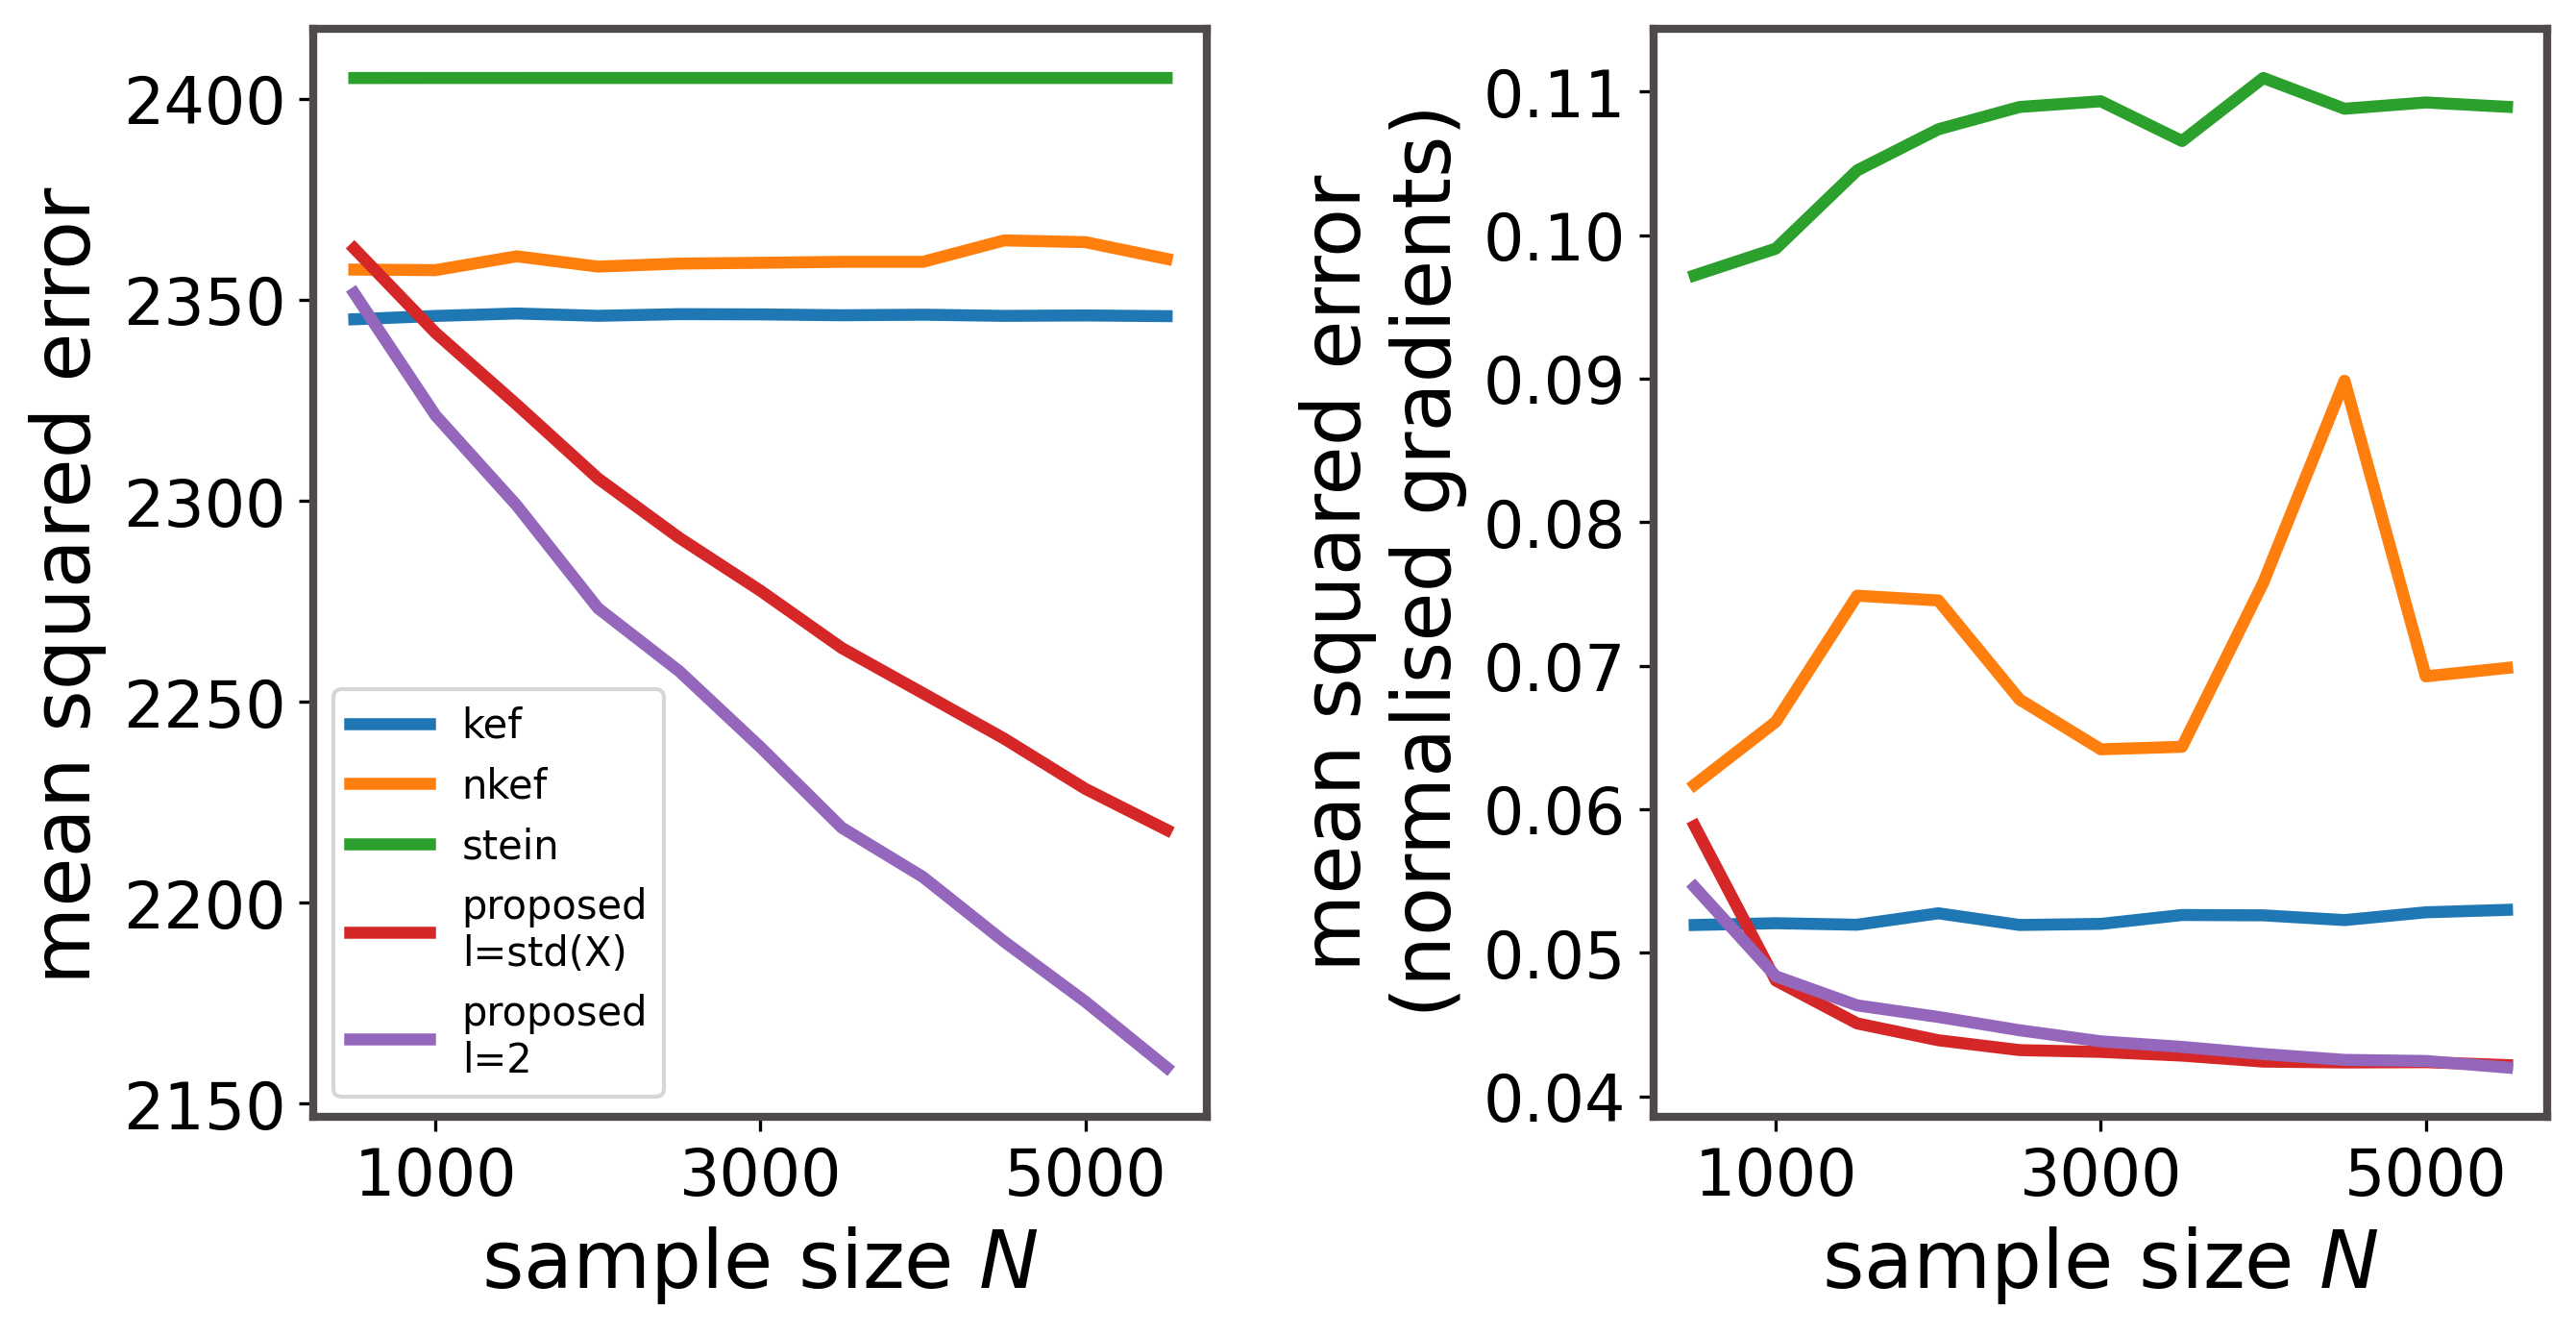

In [163]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(sizes, np.mean(errors['kef'][:,:], axis=-1), label='kef' ,lw=3)
plt.plot(sizes, np.mean(errors['nkef'][:,:], axis=-1), label='nkef',lw=3  )
plt.plot(sizes, np.mean(errors['stein'][:,:], axis=-1) , label='stein',lw=3 )
plt.plot(sizes, np.mean(errors['my1'][:,:], axis=-1) , label='proposed\nl=std(X)',lw=3 )
plt.plot(sizes, np.mean(errors['my2'][:,:], axis=-1) , label='proposed\nl=2',lw=3 )
plt.xlabel('sample size $N$')
plt.ylabel('mean squared error ')
plt.xticks([1000,3000,5000])
plt.legend()
plt.subplot(1,2,2)
plt.plot(sizes, np.mean(nerrors['kef'][:,:], axis=-1), label='kef' ,lw=3)
plt.plot(sizes, np.mean(nerrors['nkef'][:,:], axis=-1), label='nkef'  ,lw=3)
plt.plot(sizes, np.mean(nerrors['stein'][:,:], axis=-1) , label='stein',lw=3 )
plt.plot(sizes, np.mean(nerrors['my1'][:,:], axis=-1) , label='my1' ,lw=3)
plt.plot(sizes, np.mean(nerrors['my2'][:,:], axis=-1) , label='my2',lw=3 )
plt.xlabel('sample size $N$')
plt.ylabel('mean squared error\n (normalised gradients)')
plt.xticks([1000,3000,5000])
plt.subplots_adjust(wspace=0.5)
#plt.legend()
plt.savefig("comparison_estimators_consistency.png", bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')
plt.savefig("comparison_estimators_consistency.pdf", bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')

In [162]:
import pickle
to_sav = dict()

to_sav['sizes'] = sizes
to_sav['errors'] = errors
to_sav['nerrors'] = nerrors


filename = 'Data_for_comparison_estimators'
pickle.dump(to_sav, open(filename+'.dat', "wb"))